# PRMT-2240 Is the 100MB attachment limit for TPP on compressed or uncompressed attachments?

### Requirements

In order to replicate this notebook, perform the following steps:

1. Log into Splunk and run the following query for:
- 01/06/2021 00:00:00:00 to 01/07/2021 00:00:00, export the result as a csv named `6-2021-attachment-metadata.csv` and gzip it. 

```
index="spine2vfmmonitor" logReference=MPS0208
| table _time, attachmentID, conversationID, FromSystem, ToSystem, attachmentType, Compressed, ContentType, LargeAttachment, Length, OriginalBase64, internalID
```

2. Run the following Splunk query for the same time range. Export the results as a csv named `6-2021-gp2gp-messages.csv` and gzip it.

```
index="spine2vfmmonitor" service="gp2gp" logReference="MPS0053d"
| table _time, conversationID, internalID, interactionID
```

In [1]:
import pandas as pd
import numpy as np
import datetime

In [2]:
attachment_metadata_file = "s3://prm-gp2gp-data-sandbox-dev/PRMT-2240-tpp-attachment-limit/6-2021-attachment-metadata.csv.gz"
attachments = pd.read_csv(attachment_metadata_file, parse_dates=["_time"], na_values=["Unknown"], dtype={"Length": pd.Int64Dtype()})

In [3]:
gp2gp_messages_file = "s3://prm-gp2gp-data-sandbox-dev/PRMT-2240-tpp-attachment-limit/6-2021-gp2gp-messages.csv.gz"
gp2gp_messages = pd.read_csv(gp2gp_messages_file, parse_dates=["_time"])

In [4]:
transfer_data_file = "s3://prm-gp2gp-data-sandbox-dev/transfers-sample-6/2021-6-transfers.parquet"
transfers = pd.read_parquet(transfer_data_file)

In [5]:
mi_rr_extract_ack_code_30_file = "s3://prm-gp2gp-data-sandbox-dev/PRMT-2240-tpp-attachment-limit/6-2021-mi-rr-extract-ack-code-30.csv"
mi_rr_extract_ack_code_30 = pd.read_csv(mi_rr_extract_ack_code_30_file, parse_dates=["RegistrationTime"])

## Deduplicate attachment data

In [6]:
ehr_request_completed_messages = gp2gp_messages[gp2gp_messages["interactionID"] == "urn:nhs:names:services:gp2gp/RCMR_IN030000UK06"]

unique_ehr_request_completed_messages = ehr_request_completed_messages.sort_values(by="_time").drop_duplicates(subset=["conversationID"], keep="last")

In [7]:
ehr_attachments = pd.merge(attachments, unique_ehr_request_completed_messages[["internalID", "interactionID"]], on="internalID", how="inner")

## TPP Requestor large attachment failures

In [8]:
large_attachment_requestor_failure_bool = transfers["final_error_codes"].apply(lambda errs: 30 in errs)
tpp_requestor_bool = transfers["requesting_supplier"]=="SystmOne"
tpp_requestor_large_attachment_failures = transfers[large_attachment_requestor_failure_bool & tpp_requestor_bool]

In [9]:
mi_rr_extract_ack_code_30_started_in_jun_bool = mi_rr_extract_ack_code_30["RegistrationTime"].apply(lambda t: t.month == 6 and t.year == 2021)
mi_rr_error_30_june = mi_rr_extract_ack_code_30[mi_rr_extract_ack_code_30_started_in_jun_bool].copy()

#### From the Spine team work request:

Attachment metadata field definition:
- **Length** - Size in bytes of the original attachment. This should be set after Any compression andbase64 encoding(i.e. the contribution that the attachment would make to the content length of a message where it was sent in-line).

In [10]:
mi_rr_error_30_june["FailedAttachmentSize"] = mi_rr_error_30_june["RequestErrorDescription"].str.extract('(\d+)')
mi_rr_error_30_june["FailedAttachmentSize"] = mi_rr_error_30_june["FailedAttachmentSize"].astype("int").astype(pd.Int64Dtype())

# There may be some transfers that failed because the EHR extract size exceeded the limit, we are only interested in transfers that failed due to the attachment size
rejected_attachment_bool = mi_rr_error_30_june["RequestErrorDescription"].apply(lambda t: t.startswith("Attachment"))

mi_rr_error_30_june_failed_attachment_sizes = mi_rr_error_30_june[rejected_attachment_bool][["ConversationID", "RequestErrorDescription", "FailedAttachmentSize"]]

In [11]:
rejected_attachments = mi_rr_error_30_june_failed_attachment_sizes.merge(ehr_attachments, left_on=["ConversationID", "FailedAttachmentSize"], right_on=["conversationID", "Length"], how="left")

In [12]:
# If there are any na values, that means for at least one conversation we could not find an attachment of the size reported in the MI
# This would imply that the limit was reached after decompression
rejected_attachments["Compressed"].value_counts(dropna=False)

No     110
Yes      2
Name: Compressed, dtype: int64

array([[<AxesSubplot:title={'center':'FailedAttachmentSize'}>]],
      dtype=object)

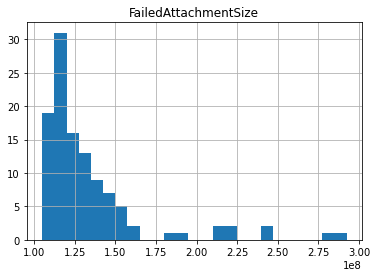

In [13]:
rejected_attachments.hist(column='FailedAttachmentSize', bins=25)